In [18]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from inspect import signature
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.sandbox.stats.multicomp import multipletests
from typing import Dict
from matplotlib import cm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score
from collections import defaultdict

# Data loading

In [6]:
from load_data import load_data
mibig_metadata, mibig_pfam, mibig_cathdb, funfams, sbp, sbp_all_pfam, bios = load_data()

(851, 20)
(918, 166)
(1519, 17)
(96, 10)
(863, 29)
(1345, 100)


In [7]:
abx_plus_data = mibig_metadata.query("Gram == 1 and (Antibacterial == 1 or Antifungal == 1) and Siderophore == 0")
abx_plus = sbp_all_pfam[sbp_all_pfam.BGC.isin(abx_plus_data.BGC)]

abx_neg_data = mibig_metadata.query("Gram == 0 and (Antibacterial == 1 or Antifungal == 1) and Siderophore == 0")
abx_neg = sbp_all_pfam[sbp_all_pfam.BGC.isin(abx_neg_data.BGC)]

print(str(abx_plus.shape[0]) + " Gram+ Antibiotic+Antifungal BGCs")
print(str(abx_neg.shape[0]) + " Gram- Antibiotic+Antifungal BGCs")

## compare G+ and G- siderophores (PFAM, CATHDB)
other_plus_data = mibig_metadata.query("Gram == 1 and (~Activities.isnull() or Siderophore==1) and Antibacterial == 0 and Antifungal == 0")
other_plus = sbp_all_pfam[sbp_all_pfam.BGC.isin(other_plus_data.BGC)]

other_neg_data = mibig_metadata.query("Gram == 0 and (~Activities.isnull() or Siderophore==1) and Antibacterial == 0 and Antifungal == 0")
other_neg = sbp_all_pfam[sbp_all_pfam.BGC.isin(other_neg_data.BGC)]

print(str(other_plus.shape[0]) + " Gram+ Other BGCs")
print(str(other_neg.shape[0]) + " Gram- Other BGCs")


131 Gram+ Antibiotic+Antifungal BGCs
27 Gram- Antibiotic+Antifungal BGCs
57 Gram+ Other BGCs
37 Gram- Other BGCs


In [45]:
abx_neg.MacB_PCD.sum()

7.0

In [8]:
cols = sbp_all_pfam.columns.drop(['BGC'])
train_cols = cols[abx_plus[cols].sum() + abx_neg[cols].sum() + other_plus[cols].sum() + other_neg[cols].sum() >= 5]

# Plot and statistics

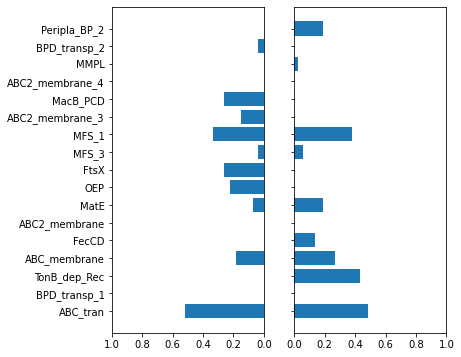

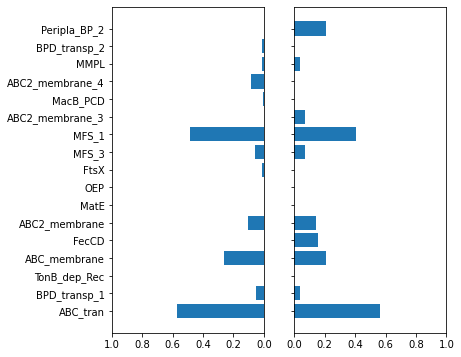

In [72]:
## Plot barchart

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

plt.rcParams["figure.figsize"] = (6,6)

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(abx_neg.sum()[train_cols].keys(), abx_neg.astype(bool).sum()[train_cols] / abx_neg.shape[0], align='center')
axes[1].barh(other_neg.sum()[train_cols].keys(), other_neg.astype(bool).sum()[train_cols] / other_neg.shape[0], align='center')
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)

axes[0].invert_xaxis()
plt.savefig("FigS3a.svg")

plt.show()

fig, axes = plt.subplots(ncols=2, sharey=True)
axes[0].barh(abx_plus.sum()[train_cols].keys(), abx_plus.astype(bool).sum()[train_cols] / abx_plus.shape[0], align='center')
axes[1].barh(other_plus.sum()[train_cols].keys(), other_plus.astype(bool).sum()[train_cols] / other_plus.shape[0], align='center')
axes[0].set_xlim(0,1)
axes[1].set_xlim(0,1)

axes[0].invert_xaxis()

plt.savefig("FigS3b.svg")

plt.show()

In [73]:
from statsmodels.sandbox.stats.multicomp import multipletests
import scipy.stats as stats

pvalues1 = []
pvalues2 = []


## Run z-tests
for pfam in train_cols:
    compare1 = [abx_plus[pfam].sum(),other_plus[pfam].sum()]
    compare2 = [abx_plus[cols.drop(pfam)].sum().sum(), other_plus[cols.drop(pfam)].sum().sum()]
    oddsratio, pvalue = stats.fisher_exact([compare1, compare2])
    pvalues1.append(pvalue)

    compare1 = [abx_neg[pfam].sum(),other_neg[pfam].sum()]
    compare2 = [abx_neg[cols.drop(pfam)].sum().sum(), other_neg[cols.drop(pfam)].sum().sum()]
    oddsratio, pvalue = stats.fisher_exact([compare1, compare2])
    pvalues2.append(pvalue)
    
    
t1 = multipletests(np.array(pvalues1),alpha=0.05,method='fdr_bh')
t2 = multipletests(np.array(pvalues2),alpha=0.05,method='fdr_bh')

i = 0
for pfam in train_cols:
    compare = [abx_plus[pfam].astype(bool).sum(),other_plus[pfam].astype(bool).sum()]
    
    if t1[1][i] < 0.05:
        print("*****")
        print(pfam)
        print("Pos Abx :" + str(int(compare[0] / abx_plus.shape[0] * 100)))
        print("Pos Other :" + str(int(compare[1] / other_plus.shape[0] * 100)))
        print(t1[1][i])

    compare = [abx_neg[pfam].astype(bool).sum(),other_neg[pfam].astype(bool).sum()]
                        
    if t2[1][i] < 0.05:
        print("*****")
        print(pfam)
        print("Neg Abx :" + str(int(compare[0] / abx_neg.shape[0] * 100)))
        print("Neg Other :" + str(int(compare[1] / other_neg.shape[0] * 100)))
        print(t2[1][i])
    i += 1

*****
TonB_dep_Rec
Neg Abx :0
Neg Other :43
0.00023262441557138008
*****
FecCD
Pos Abx :0
Pos Other :15
9.451490753585291e-08
*****
FecCD
Neg Abx :0
Neg Other :13
0.01566540937007516
*****
OEP
Neg Abx :22
Neg Other :0
0.00023262441557138008
*****
FtsX
Neg Abx :25
Neg Other :0
0.007181386433741364
*****
ABC2_membrane_3
Pos Abx :0
Pos Other :7
1.4832784362842977e-06
*****
ABC2_membrane_3
Neg Abx :14
Neg Other :0
0.004813610471892494
*****
MacB_PCD
Neg Abx :25
Neg Other :0
0.007181386433741364
*****
ABC2_membrane_4
Pos Abx :8
Pos Other :0
0.014768544371441362
*****
Peripla_BP_2
Pos Abx :0
Pos Other :21
9.618647919465847e-06


# Bring in CATHDBs and Biosynthetic genes, prep for learning

In [74]:
abx_cathdb_plus = mibig_cathdb[mibig_cathdb.BGC.isin(abx_plus_data.BGC)]
abx_cathdb_neg = mibig_cathdb[mibig_cathdb.BGC.isin(abx_neg_data.BGC)]

print(str(abx_cathdb_plus.shape[0]) + " Gram+ Antibiotic+Antifungal CATHDB BGCs")
print(str(abx_cathdb_neg.shape[0]) + " Gram- Antibiotic+Antifungal CATHDB BGCs")

other_cathdb_plus = mibig_cathdb[mibig_cathdb.BGC.isin(other_plus_data.BGC)]
other_cathdb_neg = mibig_cathdb[mibig_cathdb.BGC.isin(other_neg_data.BGC)]

print(str(other_cathdb_plus.shape[0]) + " Gram+ Other CATHDB BGCs")
print(str(other_cathdb_neg.shape[0]) + " Gram- Other CATHDB BGCs")



132 Gram+ Antibiotic+Antifungal CATHDB BGCs
25 Gram- Antibiotic+Antifungal CATHDB BGCs
59 Gram+ Other CATHDB BGCs
39 Gram- Other CATHDB BGCs


In [75]:
abx_biosyn_plus = bios[bios.BGC.isin(abx_plus_data.BGC)]
abx_biosyn_neg = bios[bios.BGC.isin(abx_neg_data.BGC)]

print(str(abx_biosyn_plus.shape[0]) + " Gram+ Antibiotic+Antifungal Biosynthetic BGCs")
print(str(abx_biosyn_neg.shape[0]) + " Gram- Antibiotic+Antifungal Biosynthetic BGCs")

other_biosyn_plus = bios[bios.BGC.isin(other_plus_data.BGC)]
other_biosyn_neg = bios[bios.BGC.isin(other_neg_data.BGC)]

print(str(other_biosyn_plus.shape[0]) + " Gram+ Other Biosynthetic BGCs")
print(str(other_biosyn_neg.shape[0]) + " Gram- Other Biosynthetic BGCs")



169 Gram+ Antibiotic+Antifungal Biosynthetic BGCs
47 Gram- Antibiotic+Antifungal Biosynthetic BGCs
79 Gram+ Other Biosynthetic BGCs
62 Gram- Other Biosynthetic BGCs


In [76]:
cathdb_gram_plus = mibig_cathdb.copy()
cathdb_gram_plus.loc[cathdb_gram_plus.BGC.isin(abx_plus_data.BGC), 'label'] = 1
cathdb_gram_plus.loc[cathdb_gram_plus.BGC.isin(other_plus_data.BGC), 'label'] = 0
# cathdb_gram_plus = cathdb_gram_plus.dropna()
# print(cathdb_gram_plus.shape)


In [77]:
## let's create our final training / testing set
pfam_gram_plus = sbp_all_pfam.copy()
pfam_gram_plus.loc[pfam_gram_plus.BGC.isin(abx_plus_data.BGC), 'label'] = 1
pfam_gram_plus.loc[pfam_gram_plus.BGC.isin(other_plus_data.BGC), 'label'] = 0
pfam_gram_plus = pfam_gram_plus.dropna()
print(pfam_gram_plus.shape)

pfam_gram_neg = sbp_all_pfam.copy()
pfam_gram_neg.loc[pfam_gram_neg.BGC.isin(abx_neg_data.BGC), 'label'] = 1
pfam_gram_neg.loc[pfam_gram_neg.BGC.isin(other_neg_data.BGC), 'label'] = 0
pfam_gram_neg = pfam_gram_neg.dropna()
print(pfam_gram_neg.shape)

cathdb_gram_plus = mibig_cathdb.copy()
cathdb_gram_plus.loc[cathdb_gram_plus.BGC.isin(abx_plus_data.BGC), 'label'] = 1
cathdb_gram_plus.loc[cathdb_gram_plus.BGC.isin(other_plus_data.BGC), 'label'] = 0
cathdb_gram_plus = cathdb_gram_plus.dropna()
print(cathdb_gram_plus.shape)

cathdb_gram_neg = mibig_cathdb.copy()
cathdb_gram_neg.loc[cathdb_gram_neg.BGC.isin(abx_neg_data.BGC), 'label'] = 1
cathdb_gram_neg.loc[cathdb_gram_neg.BGC.isin(other_neg_data.BGC), 'label'] = 0
cathdb_gram_neg = cathdb_gram_neg.dropna()
print(cathdb_gram_neg.shape)

bios_gram_plus = bios.copy()
bios_gram_plus.loc[bios_gram_plus.BGC.isin(abx_plus_data.BGC), 'label'] = 1
bios_gram_plus.loc[bios_gram_plus.BGC.isin(other_plus_data.BGC), 'label'] = 0
bios_gram_plus = bios_gram_plus.dropna()
print(bios_gram_plus.shape)

bios_gram_neg = bios.copy()
bios_gram_neg.loc[bios_gram_neg.BGC.isin(abx_neg_data.BGC), 'label'] = 1
bios_gram_neg.loc[bios_gram_neg.BGC.isin(other_neg_data.BGC), 'label'] = 0
bios_gram_neg = bios_gram_neg.dropna()
print(bios_gram_neg.shape)


(188, 30)
(64, 30)
(191, 167)
(64, 167)
(248, 101)
(109, 101)


# Do the ML

In [78]:
def plot_pr_curves(precisions, recalls, names, task, cmap_name="tab20"):
    cm = plt.get_cmap(cmap_name)

    _recalls = recalls
    _precisions = precisions
    cgen = [cm(1. * i/len(_recalls)) for i in range(len(_recalls))]

    plt.figure(figsize=(5, 5))
    for color, precision, recall, key in zip(cgen, _precisions, _recalls, names):
        step_kwargs = ({'step': 'post'}
                      if 'step' in signature(plt.fill_between).parameters
                       else {})
        plt.step(recall, precision, alpha=0.8, color=color, linewidth=5, linestyle='-',
                 where='post', label=key)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
    plt.legend()
    plt.savefig("pr_curve_abx.svg")
    plt.show()

In [91]:
## Classifier
from sklearn.preprocessing import StandardScaler

def fit_classifier(data, clf_type):
    if clf_type == 'lasso':
        clf = LogisticRegression(C=1, penalty='l1', tol=0.01, solver='saga', class_weight='balanced', max_iter=1000)
    elif clf_type == 'tree':
        clf = tree.DecisionTreeClassifier(max_depth=2, min_samples_split=3)

    X = data[data.columns.drop(['BGC', 'label'])]

    y = data['label']
    
    n_split = 5
    n_repeats = 5
    
    ## metrics
    precisions = []
    recalls = []
    accuracies = []
    auprcs = []
    
    ## cross validation
    coefs = []
    for i in range(n_repeats):
        kf = StratifiedKFold(n_splits=n_split)
        for train_index, test_index in kf.split(X,y):
            X_train, X_test = X.to_numpy()[train_index], X.to_numpy()[test_index]
            y_train, y_test = y.to_numpy()[train_index], y.to_numpy()[test_index]
            scaler = StandardScaler()
            scaler.fit(X_train)
            X_train = scaler.transform(X_train)
            X_test = scaler.transform(X_test)
            
            clf.fit(X_train, y_train)
            preds = clf.predict(X_test)
            #save scores
            precisions.append(precision_score(y_test, preds, zero_division=0))
            recalls.append(recall_score(y_test, preds))
            accuracies.append(accuracy_score(y_test, preds))
            auprcs.append(average_precision_score(y_test, preds))
            if clf_type == 'lasso':
                coef = clf.coef_.ravel()
                coefs.append(coef)
    ## calculate medians and range
    cv_precision = np.mean(precisions)
    cv_recall = np.mean(recalls)
    cv_accuracy = np.mean(accuracies)
    cv_aupcr = np.mean(auprcs)

    ## Now run on entire dataset
    scaler = StandardScaler()
    X_orig = X
    X = pd.DataFrame(scaler.fit_transform(X))
    clf.fit(X, y)
    preds = clf.predict_proba(X)
    precisions, recalls, _ = precision_recall_curve(y, preds[:, 1])
    auprc = average_precision_score(y, preds[:, 1])
    variables = []
    dfs = []
    # get features if it's a lasso 
    if clf_type == 'lasso':
        coefs = np.array(coefs)
        results = pd.DataFrame(coefs)
        results = results.rename(columns={i: f for i, f in enumerate(X_orig.columns)})
        results = results.melt(var_name='feature', value_name='vals')
        dfs.append(results)
        dfs = pd.concat(dfs)
        dfs2 = dfs[dfs.vals > 0]
        dfs = dfs[dfs.feature.isin(dfs2.feature.unique())]
        dfs = dfs.sort_values('vals', ascending=False)
        
    fit = {"precisions": precisions, "recalls": recalls, "features": dfs, "auprc": auprc, "cv_precision": cv_precision, "cv_recall":cv_recall, "cv_accuracy": cv_accuracy, "cv_aupcr": cv_aupcr}
    return fit            

In [92]:
combined_plus = pd.merge(pfam_gram_plus, bios_gram_plus, on='BGC', how='right')
combined_plus['label'] = combined_plus.label_y
del combined_plus['label_y']
del combined_plus['label_x']
combined_plus = combined_plus.fillna(0)

combined_neg = pd.merge(pfam_gram_neg, bios_gram_neg, on='BGC', how='right')
combined_neg['label'] = combined_neg.label_y
del combined_neg['label_y']
del combined_neg['label_x']
combined_neg = combined_neg.fillna(0)


results = {}
results['pfam_1'] = fit_classifier(pfam_gram_plus, clf_type='tree')
results['pfam_0'] = fit_classifier(pfam_gram_neg, clf_type='tree')
results['cath_1'] = fit_classifier(cathdb_gram_plus, clf_type='tree')
results['cath_0'] = fit_classifier(cathdb_gram_neg, clf_type='tree')
results['bios_1'] = fit_classifier(bios_gram_plus, clf_type='tree')
results['bios_0'] = fit_classifier(bios_gram_neg, clf_type='tree')
results['combined_1'] = fit_classifier(combined_plus, clf_type='tree')
results['combined_0'] = fit_classifier(combined_neg, clf_type='tree')

results['pfam_1_l'] = fit_classifier(pfam_gram_plus, clf_type='lasso')
results['pfam_0_l'] = fit_classifier(pfam_gram_neg, clf_type='lasso')
results['cath_1_l'] = fit_classifier(cathdb_gram_plus, clf_type='lasso')
results['cath_0_l'] = fit_classifier(cathdb_gram_neg, clf_type='lasso')
results['bios_1_l'] = fit_classifier(bios_gram_plus, clf_type='lasso')
results['bios_0_l'] = fit_classifier(bios_gram_neg, clf_type='lasso')
results['combined_1_l'] = fit_classifier(combined_plus, clf_type='lasso')
results['combined_0_l'] = fit_classifier(combined_neg, clf_type='lasso')


In [93]:
results_table = defaultdict(list)
for r in results:
    results_table['Task'].append(r)
    results_table['Precision (Cross Validation)'].append(results[r]['cv_precision'])
    results_table['Recall (Cross Validation)'].append(results[r]['cv_recall'])
    results_table['Accuracy (Cross Validation)'].append(results[r]['cv_accuracy'])
    results_table['AUPRC Total'].append(results[r]['auprc'])
    results_table['AUPRC (Cross Validation)'].append(results[r]['cv_aupcr'])
    
pd.DataFrame(results_table)

,Task,Precision (Cross Validation),Recall (Cross Validation),Accuracy (Cross Validation),AUPRC Total,AUPRC (Cross Validation)
0,pfam_1,0.750562,1.000000,0.766003,0.757225,0.750562
1,pfam_0,0.589091,0.292000,0.631538,0.675926,0.492629
2,cath_1,0.741497,1.000000,0.755277,0.750000,0.741497
3,cath_0,0.800000,0.360000,0.735897,0.683125,0.608718
4,bios_1,0.683234,0.921176,0.656016,0.722715,0.685157
5,bios_0,0.417063,0.420000,0.550649,0.646138,0.461667
6,combined_1,0.716964,1.000000,0.729714,0.752409,0.716964
7,combined_0,0.281538,0.242222,0.539394,0.579044,0.446788
8,pfam_1_l,0.751812,0.795556,0.671323,0.868589,0.740843
9,pfam_0_l,0.636190,0.700000,0.783333,0.938638,0.682125


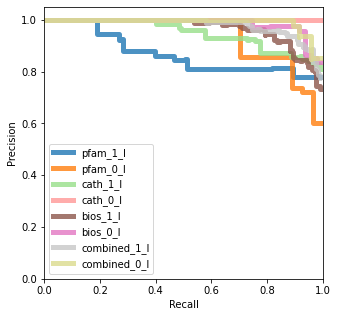

In [94]:
precisions = []
recalls = []
names = []

for r in results:
    if "_l" in r:
        names.append(r)
        precisions.append(results[r]['precisions'])
        recalls.append(results[r]['recalls'])
plot_pr_curves(precisions, recalls, names, "Antibiotics")


# Balance classes

In [95]:
from sklearn.utils import resample

random_states = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
def balance_classes(dataset):
    if dataset[dataset.label == 1].shape[0] >= dataset[dataset.label == 0].shape[0]:
        df_majority = dataset[dataset.label == 1]
        df_minority = dataset[dataset.label == 0]
    else:
        df_majority = dataset[dataset.label == 0]
        df_minority = dataset[dataset.label == 1]

        
    accuracy = []
    for r in random_states:
        df_majority_downsampled = resample(df_majority, 
                                         replace=False,    # sample without replacement
                                         n_samples=df_minority.shape[0],     # to match minority class
                                         random_state=r) # reproducible results
        dataset_new = pd.concat([df_minority, df_majority_downsampled])
        accuracy.append(fit_classifier(dataset_new, 'lasso')['cv_accuracy'])
    return(np.mean(accuracy))

print(balance_classes(pfam_gram_plus))
print(balance_classes(pfam_gram_neg))

print(balance_classes(cathdb_gram_plus))
print(balance_classes(cathdb_gram_neg))

print(balance_classes(bios_gram_plus))
print(balance_classes(bios_gram_neg))

0.5775138339920949
0.8025272727272726
0.5881050724637682
0.7924
0.5877056451612903
0.6812631578947369


# Stability analysis

In [103]:
def plot_features(dfs, name, figsize):
    plt.figure(figsize=figsize)
    
    sns.swarmplot(x='vals', y='feature', data=dfs, size=5)
    sns.boxplot(x='vals', y='feature', data=dfs, color='white')

    plt.ylabel('Protein Families')
    plt.xlabel('Effect Size')
    plt.title(name)
    plt.savefig('abx_' + name + ".svg")
    plt.show()

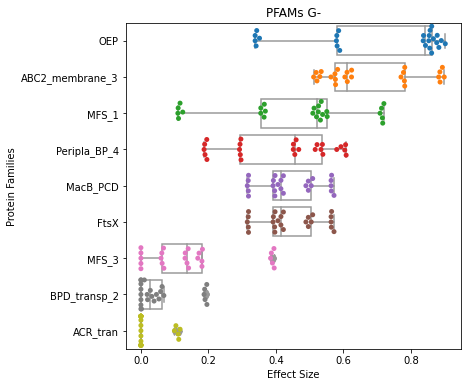

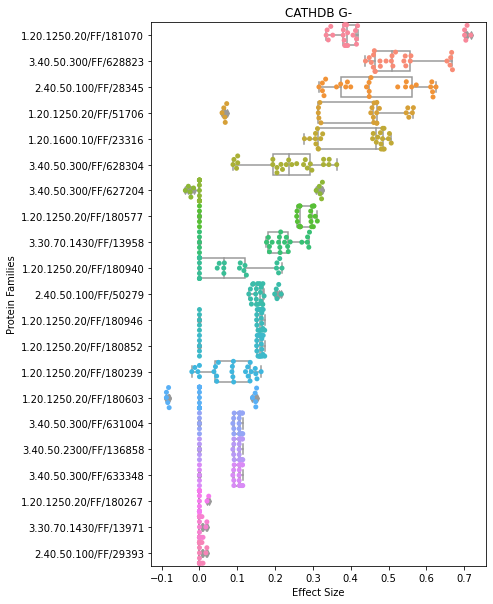

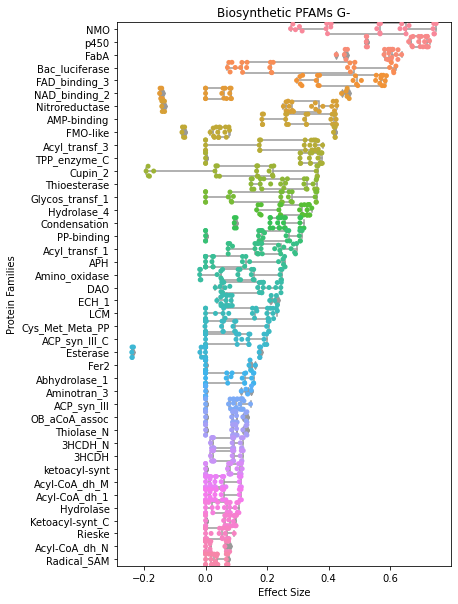

In [104]:
plot_features(results['pfam_0_l']['features'], 'PFAMs G-', (6,6))
plot_features(results['cath_0_l']['features'], 'CATHDB G-', (6,10))
plot_features(results['bios_0_l']['features'], 'Biosynthetic PFAMs G-', (6,10))

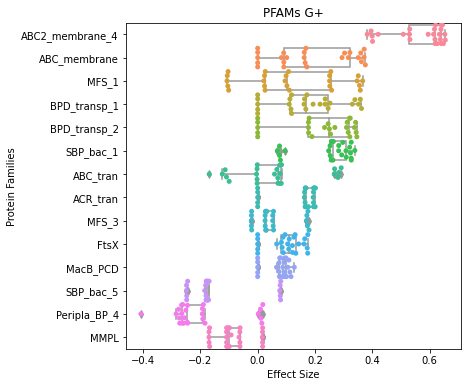

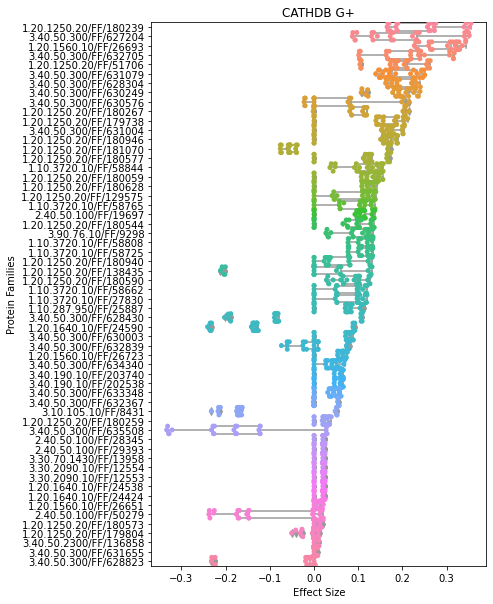

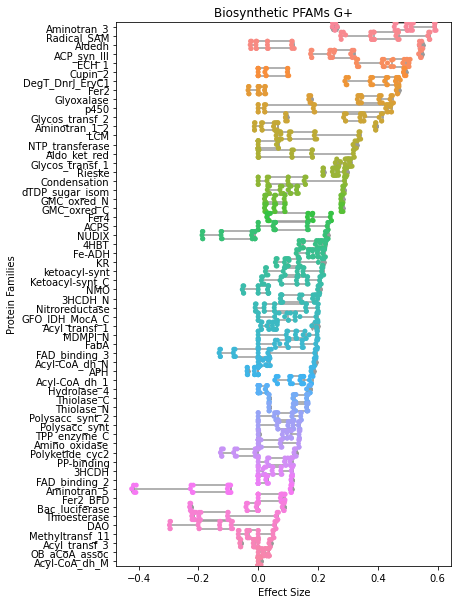

In [105]:
plot_features(results['pfam_1_l']['features'], 'PFAMs G+', (6,6))
plot_features(results['cath_1_l']['features'], 'CATHDB G+', (6,10))
plot_features(results['bios_1_l']['features'], 'Biosynthetic PFAMs G+', (6,10))